In [1]:
import os
import numpy as np
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.metrics import categorical_accuracy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Label Read In & Prep

In [2]:
np.random.seed(1)

df = pd.read_csv(r'C:\Users\casocha\Downloads\histopathologic-cancer-detection/train_labels.csv')

def append_ext(fn):
    return fn+".tif"

df["id"]=df["id"].apply(append_ext)
                   

df["label"]=df["label"].astype(str)

train_path = r'C:\Users\casocha\Downloads\histopathologic-cancer-detection\train'
valid_path = r'C:\Users\casocha\Downloads\histopathologic-cancer-detection\train'

testdf= pd.read_csv(r'C:\Users\casocha\Downloads\histopathologic-cancer-detection/sample_submission.csv')

def append_ext2(fn):
    return r'C:\Users\casocha\Downloads\histopathologic-cancer-detection\test/' + fn+".tif"

testdf["id"]=testdf["id"].apply(append_ext2)
                   
                   
testdf = testdf.drop(['label'],axis=1)

test_path = r'C:\Users\casocha\Downloads\histopathologic-cancer-detection\test/'

#### Data Read In

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="test_path",
x_col="id",
y_col=None,
batch_size=128,
seed=1,
shuffle=False,
class_mode=None,
use_mutiprocessing = True,
target_size=(96,96))

train_datagen = ImageDataGenerator(
       # horizontal_flip=True,
       #vertical_flip=True,
       #brightness_range=[0.5, 1.5],
       #fill_mode='reflect',                               
        #rotation_range=15,
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2
        validation_split=0.15
    
)


train_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=train_path,
                x_col = 'id',
                y_col = 'label',
                has_ext=False,
                subset='training',
                target_size=(96, 96),
                batch_size=128,
                seed=1,
                class_mode='binary',
                use_mutiprocessing = True
                )

validation_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=valid_path,
                x_col = 'id',
                y_col = 'label',
                has_ext=False,
                subset='validation', # This is the trick to properly separate train and validation dataset
                target_size=(96, 96),
                batch_size=128,
                seed=1,
                shuffle=False,
                class_mode='binary',
                use_mutiprocessing = True
                )

Found 57458 images.
Found 187022 images belonging to 2 classes.
Found 33003 images belonging to 2 classes.


#### Baseline Model Definition

In [21]:
#Inspired by the VGG architecture 
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same',input_shape=(96,96,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3),padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3),padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=["acc"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
activation_62 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
activation_63 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
activation_64 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 48, 48, 32)        0         
__________

In [22]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

start = time.time()
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=6,callbacks=[reducel, earlystopper]
)

end = time.time()
print("Training time: ", (end - start)/60, " minutes")

Epoch 1/6
 661/1461 [============>.................] - ETA: 9:27 - loss: 0.4883 - acc: 0.7578

C:\Anaconda\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171875). Check your callbacks.
  % delta_t_median)


1461/1461 [==============================] - 1089s 745ms/step - loss: 0.4386 - acc: 0.7929 - val_loss: 0.3472 - val_acc: 0.8500
Epoch 2/6
 662/1461 [============>.................] - ETA: 9:16 - loss: 0.3499 - acc: 0.8475

C:\Anaconda\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149485). Check your callbacks.
  % delta_t_median)


1461/1461 [==============================] - 1080s 739ms/step - loss: 0.3285 - acc: 0.8589 - val_loss: 0.3060 - val_acc: 0.8707
Epoch 3/6
 663/1461 [============>.................] - ETA: 9:15 - loss: 0.2799 - acc: 0.8839

C:\Anaconda\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148439). Check your callbacks.
  % delta_t_median)


1461/1461 [==============================] - 1078s 738ms/step - loss: 0.2653 - acc: 0.8909 - val_loss: 0.2265 - val_acc: 0.9097
Epoch 4/6
1461/1461 [==============================] - 1082s 740ms/step - loss: 0.2223 - acc: 0.9124 - val_loss: 0.2480 - val_acc: 0.8983

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/6
 665/1461 [============>.................] - ETA: 9:15 - loss: 0.1742 - acc: 0.9340

C:\Anaconda\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125553). Check your callbacks.
  % delta_t_median)


1461/1461 [==============================] - 1082s 741ms/step - loss: 0.1655 - acc: 0.9380 - val_loss: 0.1727 - val_acc: 0.9373
Epoch 6/6
 666/1461 [============>.................] - ETA: 9:15 - loss: 0.1523 - acc: 0.9446

C:\Anaconda\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125001). Check your callbacks.
  % delta_t_median)


1461/1461 [==============================] - 1082s 741ms/step - loss: 0.1499 - acc: 0.9451 - val_loss: 0.1697 - val_acc: 0.9391


In [23]:
model.evaluate_generator(generator=validation_generator,
steps=STEP_SIZE_TEST)

[0.16948769339637876, 0.9393960539919445]

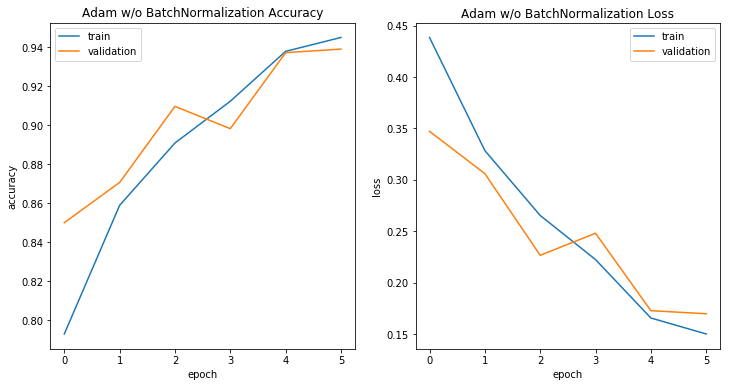

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Adam w/o BatchNormalization Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Adam w/o BatchNormalization Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [45]:
pred=model.predict_generator(test_generator,
steps=449,
verbose=1)

449/449 [==============================] - 118s 264ms/step


In [47]:
print(len(pred))

57458


In [48]:
y_test_pred=np.argmax(pred, axis=-1)  #y_test_prob.round()
len(y_test_pred)

57458

In [81]:
results = pd.DataFrame({'id':(test_generator.filenames)})
print(len(results))
#def remove_ext(id):
#    return (id.split('/,.')[1])
#results['id']=results['id'].apply(remove_ext)
df = pd.DataFrame(results.id.str.split('/',1).tolist(),
                                   columns = ['end','id'])

df['id'].replace(regex=True,inplace=True,to_replace=r'.tif',value=r'')
df.drop(['end'], axis=1,inplace=True)
print(df.head())

57458
                                         id
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5
1  95596b92e5066c5c52466c90b69ff089b39f2737
2  248e6738860e2ebcf6258cdc1f32f299e0c76914
3  2c35657e312966e9294eac6841726ff3a748febf
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6


In [82]:
df['label'] = y_test_pred
df.to_csv("submission.csv",index=False)
df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [83]:
fp = r'Downloads\models/cancer-base.hdf5'
model.save(fp)

In [ ]:
#keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=True)
Try SGD next
#optimizers.rmsprop(lr=0.001, decay=1e-6)